<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/T_SIS_edges_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# SIR

En esta parte está el código para un SIR usando agrupamiento de nodos. Se agrega la opción $Tuto=True$ para imprimir las acciones del algoritmo Gillespie y presentar los cambios en la gráfica. Se recomienda para gráficas de orden pequeño (e.g. N=10)

In [21]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf,Tuto=False):
    flag=True

    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    X_R=0
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            X_I+=1
            X_S-=1
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo 
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            X_I-=1
            X_R+=1
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo 
        if Tuto:
            print("Se genera el tiempo ",tau)
            print("Se selecciona al individuo",i)
            print("infectado por estar en el grupo con ", k_choice)
            nx.draw(G=G_network_initial,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
            plt.show()
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        
        if(X_I==0):
            flag=False
    return Historia

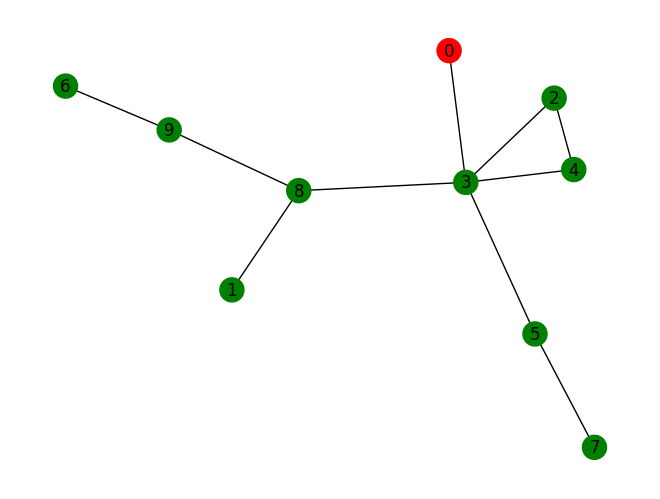

Empieza


In [97]:
N=10
n=3
G=nx.fast_gnp_random_graph(n=N,p=n/N)
X_I_indexes=[0]
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
nx.draw(G_copy,node_color=['green' if G_copy.nodes[i]['Estado:']=='Susceptible' else 'red' if G_copy.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in range(len(list(G_copy.nodes)))],with_labels=True)
plt.show()
print("Empieza")
H=Gillespie_Direct_Method_Network(beta=1.25,gamma=1,N=N,X_I_indexes=[0],G_network_initial=G_copy,T=np.inf,Tuto=False)

# SIS

Voy a hacer la modificación hacia el SIS, igual de forma gráfica usando $Tuto=True$. Además, se agrega un parámetro times_edges_count que es un arreglo de tiempos en el que se contará el número de conexiones Susceptibles-Infecciosas en la gráfica.

In [226]:
def Monte_Carlo_Step_exp_mod(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(len(X_I_indexes)==1):#Se puede acabar
        u_2=0#forzar la infeccion
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación--
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network_SIS(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf,Tuto=False):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    counter=0
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in G_network_initial.nodes():
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    hist_N_SI=[[len(list(G_network_initial.neighbors(X_I_indexes[0]))),1]]
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(int(list(dict_num_contacts.keys())[-1])+1):#Podria no ser continuo? digamos k=0,1,2,5
            k=int(k)
            Lambdas.append(beta*len(dict_num_contacts[str(k)])*k)
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp_mod(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            X_I+=1
            X_S-=1
            #num_cont_inf_por_indice[new_reaction]=0#Una vez que se infecta, ignoramos momentaneamente el número de contactos infecciosos que tenía, pues ya no se puede volver a contagiar.
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo 
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error. Pero ya está arreglado.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)# remove es con busqueda
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:# Paso de infeccioso a susceptible otra vez.
            X_I-=1
            X_S+=1
            G_network_initial.nodes[new_reaction]['Estado:']='Susceptible'
            #------------------ Volvemos a contar sus contactos infecciosos.
            num_cont_inf_por_indice[new_reaction]=0
            for neig in G_network_initial.neighbors(new_reaction):
                if(G_network_initial.nodes[neig]['Estado:']=='Infeccioso'):
                    num_cont_inf_por_indice[new_reaction]+=1
            #-------------------
            X_I_indexes.pop(new_reaction_index)#Lo saca de infecciosos
            #----------------- Lo volvemos a ubicar en susceptibles
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            if(num_cont_inf_por_indice[new_reaction]>num_max_cont):#Si mas de uno crea una categoria, hay error.
                for dif in range(num_max_cont+1,int(num_cont_inf_por_indice[new_reaction]+1)):
                    dict_num_contacts[str(dif)]=[]
                dict_num_contacts[str(int(num_cont_inf_por_indice[new_reaction]))]=[new_reaction]
            else:
                dict_num_contacts[str(int(num_cont_inf_por_indice[new_reaction]))].append(new_reaction)
            #-----------------
            i=new_reaction
            #print(i, "es el que se va a recuperar")
            #----------------- Actualizamos el numero de contactos de sus vecinos.
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                #print("estoy en el vecino ",vecino," con estatus: ",G_network_initial.nodes[vecino]['Estado:'])
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)#Actualizamos el numero de contactos infecciones en -1
                    #print("lo intento quitar del conjunto de ",num_cont_del_vecino, " vecinos infecciosos. i.e.", dict_num_contacts[str(int(num_cont_del_vecino))])
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion

            #-------------------------------------------
        t+=tau #Actualiza el tiempo 
        if Tuto:
            print("Se genera el tiempo ",tau)
            print("Se selecciona al individuo",i)
            print("infectado por estar en el grupo con ", k_choice)
            nx.draw(G=G_network_initial,node_color=['green' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'red' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'gray' for i in G.nodes()],with_labels=True)
            plt.show()
        X_I=len(X_I_indexes)
        X_S=N-X_I
        N_SI=0
        for node in G_network_initial.nodes():
            if G_network_initial.nodes[node]['Estado:']=='Susceptible':
                for neig in G_network_initial.neighbors(node):
                    if G_network_initial.nodes[neig]['Estado:']=='Infeccioso':
                        N_SI+=1
        hist_N_SI.append([N_SI,X_I])
        Historia.append([t,X_S,X_I])#Focus
        counter+=1
        if(X_I==0 or t>T):
            flag=False
    return Historia,hist_N_SI

In [346]:
N=1200
n=2
G=nx.random_regular_graph(n,N)
G=nx.convert_node_labels_to_integers(G,ordering='default',)
while(nx.is_connected(G)==False):
    N=1200
    n=2
    G=nx.random_regular_graph(n,N)
    G=nx.convert_node_labels_to_integers(G,ordering='default',)
X_I_indexes=[list(G.nodes)[int(2*i)] for i in range(600)]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()
print("Empieza")
np.random.seed(2)
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1.1,gamma=1,N=N,X_I_indexes=X_I_indexes,G_network_initial=G_copy,T=1000,Tuto=False)
print(len(H))

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 398, 400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420,

In [347]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
conteo_promedio['approx']=r

In [348]:
conteo_promedio

,N_SI,approx
k,,
1,2.000000,1.998333
2,2.511723,3.993333
3,3.029596,5.985000
4,3.532516,7.973333
5,3.955407,9.958333
...,...,...
660,481.800000,594.000000
661,454.000000,593.798333
662,444.000000,593.593333


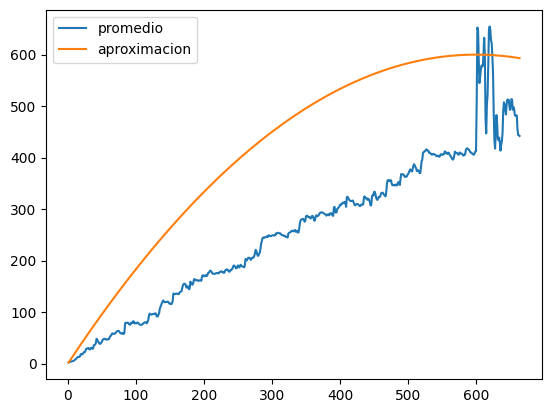

In [349]:
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion'])

In [259]:
N=1000
n=200
G=nx.random_regular_graph(n,N)
print(G.nodes())
G=nx.convert_node_labels_to_integers(G,ordering='default',)
print(G.nodes())
X_I_indexes=[list(G.nodes)[0]]
print(X_I_indexes)
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
G_copy=G.copy()

print("Empieza")
H,conteo=Gillespie_Direct_Method_Network_SIS(beta=1.25,gamma=1,N=N,X_I_indexes=[0],G_network_initial=G_copy,T=10,Tuto=False)
print(len(H))

[785, 833, 54, 385, 212, 971, 587, 848, 298, 745, 339, 746, 394, 453, 53, 160, 490, 915, 89, 571, 113, 965, 185, 279, 589, 894, 336, 448, 341, 792, 396, 499, 47, 345, 107, 492, 961, 198, 514, 203, 858, 263, 909, 247, 376, 338, 494, 450, 735, 202, 633, 348, 458, 7, 165, 540, 628, 256, 869, 204, 679, 691, 797, 751, 350, 504, 503, 102, 402, 162, 594, 864, 201, 381, 313, 622, 60, 176, 13, 330, 656, 403, 515, 408, 859, 119, 756, 62, 222, 158, 684, 457, 405, 561, 4, 217, 214, 993, 709, 972, 459, 206, 351, 398, 521, 57, 228, 174, 813, 117, 325, 982, 452, 757, 75, 807, 106, 120, 168, 998, 264, 706, 704, 978, 19, 875, 69, 238, 449, 921, 164, 475, 755, 916, 34, 166, 221, 410, 881, 470, 932, 588, 181, 829, 465, 616, 163, 223, 373, 999, 32, 123, 824, 178, 531, 370, 701, 86, 942, 461, 819, 810, 973, 669, 768, 180, 577, 175, 233, 328, 367, 135, 834, 78, 300, 301, 570, 762, 611, 763, 41, 418, 473, 822, 983, 421, 639, 863, 984, 285, 778, 665, 319, 362, 477, 948, 35, 603, 379, 413, 511, 532, 535, 926, 

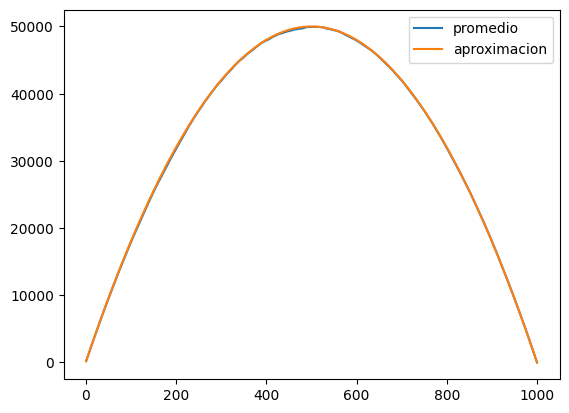

In [260]:
conteo_data=pd.DataFrame(conteo,columns=['N_SI','k'])
conteo_promedio=conteo_data.groupby(['k']).mean()
r=[]
for i in range(1,len(conteo_promedio)+1):
    r.append(i*((N-i)/N)*n)
conteo_promedio['approx']=r
plt.plot(conteo_promedio)
plt.legend(['promedio','aproximacion'])